In [2]:
import mne
import sqlite3
%pylab inline

mne.set_log_level('WARNING')

Populating the interactive namespace from numpy and matplotlib


/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/ip

In [3]:
raw = mne.io.read_raw_brainvision('/Volumes/Store/Avner/POUYAN-BRAIN/pouyan.vhdr')
#raw = mne.io.read_raw_eeglab('/home/avnerus/Code/eegtest/EEG/resampled_500.set')
#raw = mne.io.read_raw_brainvision('/home/avnerus/Code/eegtest/EEG/test2.vhdr')
print(raw.info)

<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2
    chs : list | 33 items (EEG: 32, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    filename : unicode | /Volumes/S.../pouyan.eeg
    highpass : float | 0.1 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 1000.0 Hz
    meas_date : int | 1462634396
    nchan : int | 33
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    hpi_subsystem : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
>


In [4]:
print(list(raw.ch_names))

[u'Fp1', u'Fp2', u'F7', u'F3', u'Fz', u'F4', u'F8', u'FC5', u'FC1', u'FC2', u'FC6', u'T7', u'C3', u'Cz', u'C4', u'T8', u'TP9', u'CP5', u'CP1', u'CP2', u'CP6', u'TP10', u'P7', u'P3', u'Pz', u'P4', u'P8', u'PO9', u'O1', u'Oz', u'O2', u'PO10', 'STI 014']


In [5]:
events = mne.find_events(raw)

In [6]:
print (events)

[[1457411       0       3]
 [1490754       0       2]]


In [7]:
# Pick the centro-parietal channels
raw.preload = True
centro_parietal_channels = ['C3','Cz','C4','CP1','CP2','CP5','CP6','P3','Pz','P4']
specific_chans = raw.pick_channels(centro_parietal_channels, copy=True)
print(specific_chans)

<RawBrainVision  |  n_channels x n_times : 10 x 1524790>


In [8]:

#FIRST INDEX WORK AROUND
pouyan_sec = 48 * 60 + 30.16
last_event_sec = specific_chans.times[1490754]
first_event_sec = last_event_sec - pouyan_sec
print("Total Pouyan time: %f" % (pouyan_sec))
#pouyan_start = indexes[0] - pouyanMs

start, stop = specific_chans.time_as_index([first_event_sec,last_event_sec])  # 10 s to 20 s data segment
print(start,stop)


Total Pouyan time: 2910.160000
(35673, 1490754)


In [9]:
specific_chans = specific_chans.load_data()
specific_chans.preload = False
data, times = specific_chans[:, start:stop]
print(specific_chans)

<RawBrainVision  |  n_channels x n_times : 10 x 1524790>


In [10]:
print(len(data[0]))

1455081


In [11]:
def get_lpp(index):    
    first_index = int(index + raw.info['sfreq'] * 0.4)
    last_index = int(index + raw.info['sfreq'] * 0.7)
    if last_index < len(data[0]):
        #print("Will get maximum value between index %d and %d" % (first_index, last_index))       
        
        max_amplitude = data[:,first_index:last_index + 1].sum(axis=0).max()
        present_value = data[:,index].sum()
        
        lpp  = max_amplitude - present_value
        return lpp
    else:
        return 0
        
lpp_values = []
for i in range(len(data[0])):
    lpp_values.append(get_lpp(i))

               

/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


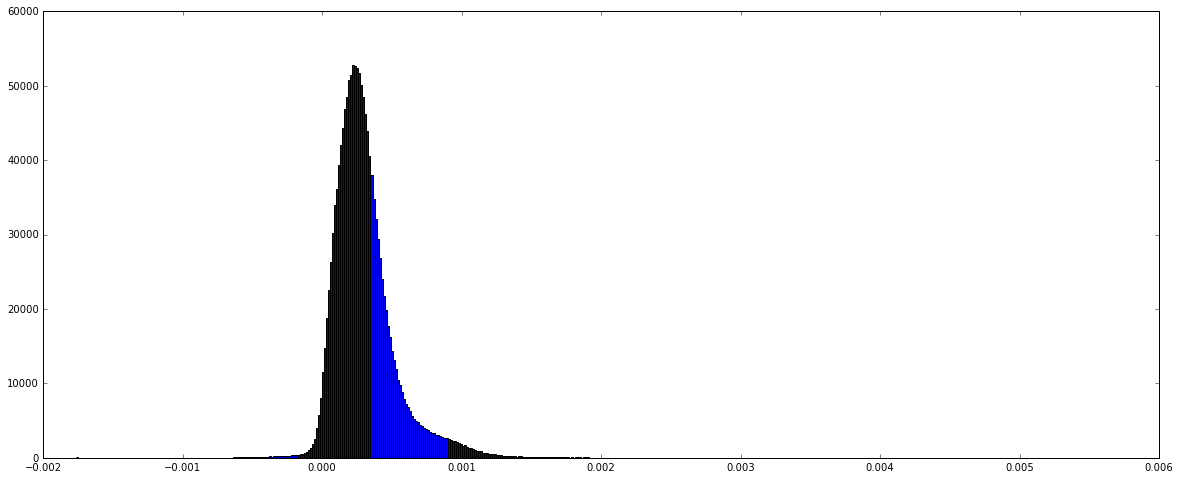

In [12]:
plt.rcParams["figure.figsize"] = [20.0,8.0]
a = hist(lpp_values, bins=500)


In [17]:
print(a[1][160])

0.000564972


In [1]:
conn = sqlite3.connect('pouyan_eeg.db')
c = conn.cursor()

NameError: name 'sqlite3' is not defined

In [23]:
# Create table
c.execute('''CREATE TABLE data
             (
             channel0 real, 
             channel1 real, 
             channel2 real, 
             channel3 real, 
             channel4 real, 
             channel5 real, 
             channel6 real, 
             channel7 real, 
             channel8 real, 
             channel9 real, 
             lpp real)''')

/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  d

In [24]:
channels = []
for value_index in range(len(data[0])):
    all_channels = []
    for channel_index in range(10):
        all_channels.append(data[channel_index][value_index])
    all_channels.append(lpp_values[value_index])
        
    channels.append(tuple(all_channels))      
    
    
#channel0 = map(lambda x: (0,x), data[0])


In [25]:
#print(data[1][1])

In [26]:
c.executemany('INSERT INTO data VALUES (?,?,?,?,?,?,?,?,?,?,?)', channels)

In [27]:
conn.commit()
conn.close()